### Экспериментальная мультимодальная система, основанная на текстовом якоре

[Ссылка на архив с данными с ноутбука, содержимое распаковать в папку data](https://drive.google.com/file/d/1pO8gCmjRvnu8Q9-aIK7w7aV7PrcnY0Hj/view?usp=sharing)

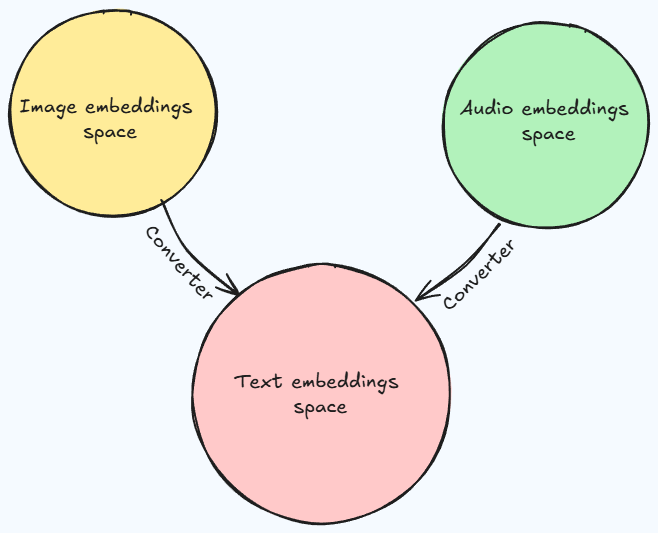

In [1]:
import pandas as pd
from params import *
from data import *
import pickle
from models import *
import os
from torch import nn
from torch.optim import Adam
from train import Trainer
from eval import *
from metrics import *
from sklearn.manifold import TSNE

d:\conda\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# читаем датафреймы с разметкой
it = pd.read_csv('data/mnist/image.csv')
at = pd.read_csv('data/mnist/audio.csv')

In [3]:
it.head()

,path,y
0,data/mnist/images/0.jpg,5
1,data/mnist/images/1.jpg,0
2,data/mnist/images/2.jpg,4
3,data/mnist/images/3.jpg,1
4,data/mnist/images/4.jpg,9


#### Переразмечаем датафреймы в стандартный формат

Парсер требует данные в виде:

Соответствие переменных и колонок:  
- `OBJECT1_COLUMN_NAME` → `object1`  
- `OBJECT2_COLUMN_NAME` → `object2`  
- `TYPE1_COLUMN_NAME` → `type1`  
- `TYPE2_COLUMN_NAME` → `type2`

| object1                     | object2 | type1 | type2 |
|-----------------------------|---------|-------|-------|
| data/mnist/images/0.jpg     | 5       | img   | text  |
| data/mnist/images/1.jpg     | 0       | img   | text  |
| data/mnist/images/2.jpg     | 4       | img   | text  |
| data/mnist/images/3.jpg     | 1       | img   | text  |
| data/mnist/images/4.jpg     | 9       | img   | text  |

**Важно!** object2 и type2 должны быть текстом, те ядром(сейчас весь код написан под текст, пока что), изображения и аудио должны быть в виде пути к изображению/wav файлу

In [4]:
it['y'] = it['y'].astype(str)
it[TYPE1_COLUMN_NAME] = TYPE_IMAGE
it[TYPE2_COLUMN_NAME] = TYPE_TEXT
it.rename(columns={
    "path": OBJECT1_COLUMN_NAME,
    "y": OBJECT2_COLUMN_NAME
}, inplace=True)

at['y'] = at['y'].astype(str)
at[TYPE1_COLUMN_NAME] = TYPE_AUDIO
at[TYPE2_COLUMN_NAME] = TYPE_TEXT
at.rename(columns={
    "pths": OBJECT1_COLUMN_NAME,
    "y": OBJECT2_COLUMN_NAME
}, inplace=True)

In [5]:
ndf = pd.concat([it, at], ignore_index=True)

#### Загружаем предпосчитанные(оригинальные) эмбеддинги

In [6]:
base_path = "data/mnist/"

with open(os.path.join(base_path, 'id_audio.pkl'), 'rb') as f:
    id_audio = pickle.load(f)

with open(os.path.join(base_path, 'id_image.pkl'), 'rb') as f:
    id_image = pickle.load(f)

with open(os.path.join(base_path, 'id_text.pkl'), 'rb') as f:
    id_text = pickle.load(f)

In [7]:
initial = InitialDataset(ndf) # Связывает id и оригинальных контент

print('Initial Dataset created')

Initial Dataset created


In [8]:
orig_embs = id_image | id_text | id_audio

#### Создаем датасеты и обучаем проекторы

In [9]:
ds = ID_Dataset(initial.return_id_df(mode=TYPE_IMAGE), orig_embs) # Датасет pytorch для обучения
dataloader = DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
model_images = ConverterModel(512, 768).to(DEVICE)
optim = Adam(model_images.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [10]:
trainer = Trainer(
    model=model_images,
    dataset=ds,
    dl=dataloader,
    epochs=3,
    batch_size=TRAIN_BATCH_SIZE,
    optimizer=optim,
    criterion=criterion
)

model_images = trainer.train()

100%|██████████| 118/118 [00:04<00:00, 28.41it/s]


Epoch 1. Loss = 4.2691320906840247e-05


100%|██████████| 118/118 [00:01<00:00, 116.11it/s]


Epoch 2. Loss = 4.8653533450959685e-06


100%|██████████| 118/118 [00:01<00:00, 115.53it/s]

Epoch 3. Loss = 2.615202694400409e-06


In [11]:
i_embs = ds.get_embs_from_ids(initial.return_ids_of_objects(TYPE_IMAGE))
i_res = encode_tensors(model_images, i_embs)
i_dict = {i: v for i, v in zip(initial.return_ids_of_objects(TYPE_IMAGE), i_res)}

100%|██████████| 118/118 [00:00<00:00, 377.37it/s]


In [12]:
ds = ID_Dataset(initial.return_id_df(mode=TYPE_AUDIO), orig_embs)
dataloader = DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
model_audio = ConverterModel(512, 768).to(DEVICE)
optim = Adam(model_audio.parameters(), lr=5e-4)
criterion = nn.MSELoss()

print('Starting trainining...')

trainer = Trainer(
    model=model_audio,
    dataset=ds,
    dl=dataloader,
    epochs=5,
    batch_size=TRAIN_BATCH_SIZE,
    optimizer=optim,
    criterion=criterion
)

model_audio = trainer.train()


Starting trainining...


100%|██████████| 59/59 [00:00<00:00, 117.86it/s]


Epoch 1. Loss = 3.7531629601517125e-05


100%|██████████| 59/59 [00:00<00:00, 117.97it/s]


Epoch 2. Loss = 9.87247169348393e-06


100%|██████████| 59/59 [00:00<00:00, 115.98it/s]


Epoch 3. Loss = 4.279451637501097e-06


100%|██████████| 59/59 [00:00<00:00, 116.33it/s]


Epoch 4. Loss = 3.0854866999163733e-06


100%|██████████| 59/59 [00:00<00:00, 95.07it/s]


--- Metric ---
Mean = 0.9915575385093689
STD = 0.018058806657791138
median = 0.997695803642273



In [13]:
a_embs = ds.get_embs_from_ids(initial.return_ids_of_objects(TYPE_AUDIO))
a_res = encode_tensors(model_audio, a_embs)
a_dict = {i: v for i, v in zip(initial.return_ids_of_objects(TYPE_AUDIO), a_res)}

100%|██████████| 59/59 [00:00<00:00, 350.56it/s]


In [14]:
ready = Ready_Embeddings_Dataset( # Связывание готовых эмбов и id
    texts=id_text,
    images=i_dict,
    audios=a_dict
)

In [15]:
tsne = TSNE()
d = tsne.fit_transform(a_res)

d:\conda\envs\torch\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\conda\envs\torch\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\conda\envs\torch\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\conda\envs\torch\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\conda\envs\torch\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
            

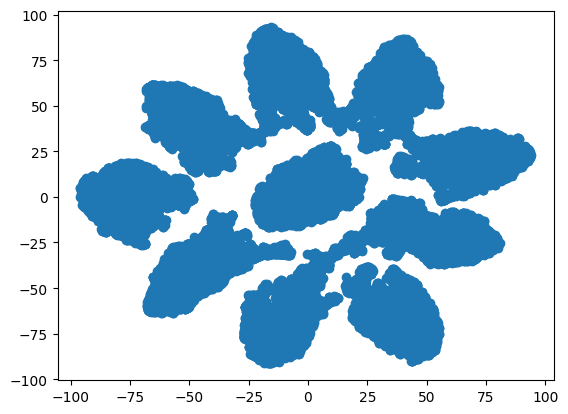

In [16]:
plt.scatter(d[:, 0], d[:, 1])
plt.show()

#### Валидация

##### Text --> Image

---- SAMPLE 1 ----
9
--- SEARCH BY TEXT -> IMAGES ---


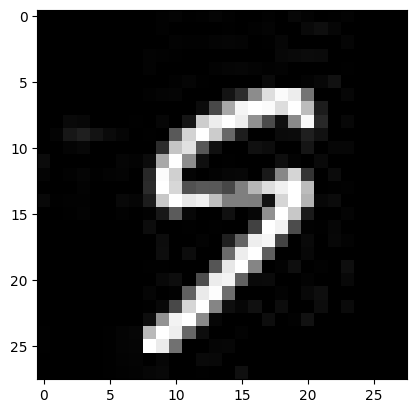

In [17]:
visual_validation(initial, ready, n_samples=1, n_neib=1, sby=TYPE_TEXT)

##### Image --> Text

---- SAMPLE 1 ----


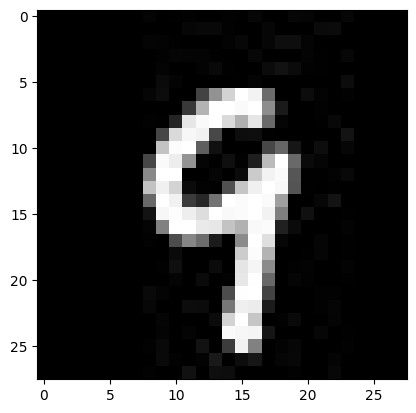

--- SEARCH BY IMAGE -> TEXTS ---
9


In [18]:
visual_validation(initial, ready, n_samples=1, n_neib=1, sby=TYPE_IMAGE)

##### Audio --> Image

>Примечание: у мнист датасета записи очень тихие, тч не пугайтесь, если там кажется тишина

---- SAMPLE 1 ----


--- SEARCH BY AUDIO -> IMAGE ---


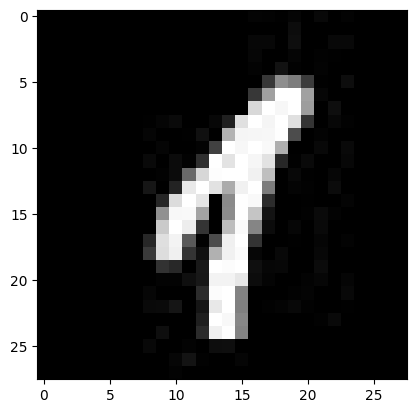

In [19]:
visual_validation(initial, ready, n_samples=1, n_neib=1, sby=TYPE_AUDIO)

#### VAE Experiment

Train:
img_emb --> img

Val:
object --> img

In [54]:
ids = initial.return_ids_of_objects(TYPE_IMAGE)

In [55]:
x = []
for i in ids:
    x.append(ready.get_image_emb_by_id(i))
x = torch.stack(x)

In [56]:
from torchvision.io import read_image

In [57]:
y = []
for i in tqdm(ids):
    y.append(read_image(initial.get_object_by_global_id(i).content))
y = torch.stack(y)

100%|██████████| 60000/60000 [00:06<00:00, 9202.49it/s]


In [ ]:
y = y / 255

In [181]:
import torch
import torch.nn as nn

class ImprovedDecoder(nn.Module):
    def __init__(self, embedding_dim=768):
        super().__init__()
        
        self.init_size = 7
        # Убираем BatchNorm1d или заменяем на LayerNorm
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 128 * self.init_size ** 2),
            # nn.BatchNorm1d(128 * self.init_size ** 2),  # УБИРАЕМ ЭТУ СТРОКУ
            nn.LeakyReLU(0.2)
        )
        
        self.conv_blocks = nn.Sequential(
            # 7x7 -> 14x14
            nn.ConvTranspose2d(128, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # 14x14 -> 28x28  
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [211]:
vae = ImprovedDecoder().to(DEVICE)

In [212]:
ds = TensorDataset(x, y)
dl = DataLoader(ds, batch_size=512, shuffle=True, pin_memory=True)
optim = Adam(vae.parameters(), lr=1e-3)

In [213]:
loss = nn.L1Loss()

In [214]:
epochs = 5

In [215]:
for e in range(epochs):
    ttl = 0
    for xb, yb in tqdm(dl):

        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optim.zero_grad()
        pred = vae(xb)
        ls = loss(pred, yb)
        ttl += ls.item()
        ls.backward()
        optim.step()
    print(f'Epoch {e+1}. Loss = {ttl / dl.batch_size}')

100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Epoch 1. Loss = 0.03179348885896616


100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Epoch 2. Loss = 0.024775788362603635


100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


Epoch 3. Loss = 0.02434135024668649


100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Epoch 4. Loss = 0.024225473272963427


100%|██████████| 118/118 [00:22<00:00,  5.34it/s]

Epoch 5. Loss = 0.02418012174894102


In [216]:
tp = x[0].unsqueeze(0)

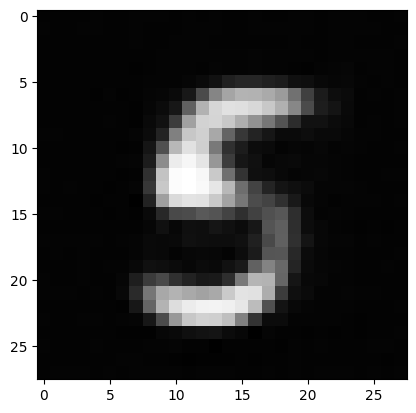

In [217]:
plt.imshow(vae(tp.to(DEVICE)).cpu().squeeze(0).permute(1,2,0).detach().numpy(), cmap='gray')
plt.show()

data/mnist/audio/57/4_57_26.wav


C:\Users\ddimo\AppData\Local\Temp\ipykernel_8536\2900757246.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tpred = torch.tensor(ready.get_audio_emb_by_id(i)).unsqueeze(0)


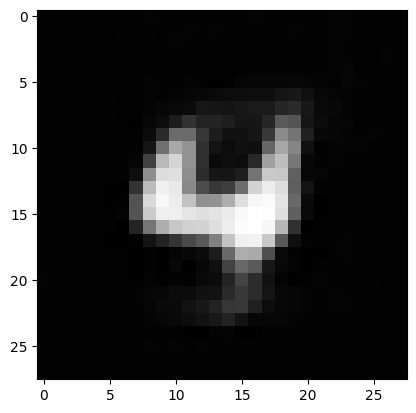

In [243]:
et = TYPE_AUDIO
pids = initial.return_ids_of_objects(et)
i = pids[randint(0, len(pids))]
initial.get_object_by_global_id(i).show()
print(initial.get_object_by_global_id(i).content)
tpred = torch.tensor(ready.get_audio_emb_by_id(i)).unsqueeze(0)
plt.imshow(vae(tpred.to(DEVICE)).cpu().squeeze(0).permute(1,2,0).detach().numpy(), cmap='gray')
plt.show()